In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, average_precision_score,
                             roc_curve, roc_auc_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split


import os
import sys
""" Workaround for notebooks to import packages from the parent folder """
# Get the project root directory by navigating up from the current directory
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root:", project_root)
from tools import config


Project root: /Users/angelo/Desktop/THESIS/Financial-dataset-for-Anomaly-Detection


In [2]:

def evaluate_lr_old(y_pred, y_proba, y_test):
   # Accuracy, confusion matrix, classification report
   print("Accuracy:", accuracy_score(y_test, y_pred))
   print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
   print("Classification Report:\n", classification_report(y_test, y_pred))

   # (1) Average Precision
   avg_precision = average_precision_score(y_test, y_proba)
   print("Average Precision:", avg_precision)

   # (2) Recall at 100
   top_indices = np.argsort(y_proba)[::-1][:100]
   y_top_100 = y_test.iloc[top_indices]
   recall_at_100 = y_top_100.sum() / y_test.sum()
   print("Recall at 100:", recall_at_100)

   # (3) ROC Curve and AUC
   fpr, tpr, thresholds = roc_curve(y_test, y_proba)
   roc_auc = roc_auc_score(y_test, y_proba)
   print("ROC AUC:", roc_auc)

   # Plot ROC Curve
   plt.figure(figsize=(6, 4))
   plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
   plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
   plt.title("Receiver Operating Characteristic")
   plt.xlabel("False Positive Rate")
   plt.ylabel("True Positive Rate")
   plt.legend()
   plt.show()

   # TODO: REPLACE WITH ROC PR

# (add standard deviation )
def evaluate_lr(y_true, y_pred, y_proba):
    """
    Prints and returns classification metrics for a given set of predictions.
    """
    # 1) Basic classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    # 2) Average Precision
    avg_precision = average_precision_score(y_true, y_proba)

    # 3) Recall at 100
    top_indices = np.argsort(y_proba)[::-1][:100]
    recall_at_100 = y_true.iloc[top_indices].sum() / y_true.sum() if y_true.sum() > 0 else 0.0

    # 4) ROC AUC
    #    Need at least 2 classes present in y_true; otherwise, roc_auc_score can fail
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, y_proba)
    else:
        roc_auc = 0.0

    # Print them out
    # print("Accuracy:", accuracy)
    # print("Confusion Matrix:\n", cm)
    # print("Classification Report:\n", cr)
    # print("Average Precision:", avg_precision)
    # print("Recall at 100:", recall_at_100)
    # print("ROC AUC:", roc_auc)

    # Plot ROC Curve
    # fpr, tpr, _ = roc_curve(y_true, y_proba)
    # plt.figure(figsize=(6, 4))
    # plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    # plt.title("Receiver Operating Characteristic")
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.legend()
    # plt.show()

    # Return the metrics in a dictionary
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': cr,
        'average_precision': avg_precision,
        'recall_at_100': recall_at_100,
        'roc_auc': roc_auc
    }


def group_train_test_split(df, group_col='cik', label_col='label',
                           test_size=0.2, random_state=42):
    """
    Splits df so that entire groups (ciks) end up in train or test.
    Ensures at least one positive in each split if possible.
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    y = df[label_col]

    for train_idx, test_idx in gss.split(df, y, groups):
        train_df = df.iloc[train_idx]
        test_df  = df.iloc[test_idx]

        # Check presence of positives in each split
        if train_df[label_col].sum() > 0 and test_df[label_col].sum() > 0:
            return train_df, test_df

    # If its not possible to split so that both have positives we return the first attempt.
    return train_df, test_df


# Logistic Regression (Numeric columns only)

In [3]:

# Load the dataset
# df = pd.read_csv(config.POST_PROCESSED_DATASET_FILEPATH)
df = pd.read_csv(os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv'))


# Drop irrelevant columns
columns_to_drop = ['company','period_of_report','gvkey',
                   'filing_date','year','accessionNumber','reportDateIndex',
                   'datadate', 'filename', 'can_label', 'qualified', 'cik_year', 'gc_list',
                   'bankruptcy_date_1','bankruptcy_date_2','bankruptcy_date_3',
                   'form','primaryDocument','isXBRL',
                   'net_increase_decrease_in_cash'
                   ]
df.drop(columns=columns_to_drop, axis=1, inplace=True)
print("cols remaining: ", df.columns)





cols remaining:  Index(['cik', 'label', 'bankruptcy_prediction_split', 'revenues',
       'operating_expenses', 'operating_income', 'net_income',
       'earnings_per_share_basic', 'earnings_per_share_diluted',
       'total_current_assets', 'total_noncurrent_assets', 'total_assets',
       'total_current_liabilities', 'total_noncurrent_liabilities',
       'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
       'net_cash_from_operating_activities',
       'net_cash_from_investing_activities',
       'net_cash_from_financing_activities', 'cash',
       'other_comprehensive_income'],
      dtype='object')


/var/folders/r5/zfpmdh1s1cq71h27b38f0znm0000gn/T/ipykernel_21763/3978287983.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv'))


LogisticRegression()

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    average_precision_score, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit





# Load the dataset
# df = pd.read_csv(config.POST_PROCESSED_DATASET_FILEPATH)
import os
import sys
""" Workaround for notebooks to import packages from the parent folder """
# Get the project root directory by navigating up from the current directory
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root:", project_root)
from tools import config
df = pd.read_csv(os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv'))


# Drop irrelevant columns
columns_to_drop = ['company','period_of_report','gvkey',
                   'filing_date','year','accessionNumber','reportDateIndex',
                   'datadate', 'filename', 'can_label', 'qualified', 'cik_year', 'gc_list',
                   'bankruptcy_date_1','bankruptcy_date_2','bankruptcy_date_3',
                   'form','primaryDocument','isXBRL',
                   'net_increase_decrease_in_cash'
                   ]
df.drop(columns=columns_to_drop, axis=1, inplace=True)
print("cols remaining: ", df.columns)

def group_train_test_split(df, group_col='cik', label_col='label',
                           test_size=0.2, random_state=42):
    """
    Splits df so that entire groups (ciks) end up in train or test.
    Ensures at least one positive in each split if possible.
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    y = df[label_col]

    for train_idx, test_idx in gss.split(df, y, groups):
        train_df = df.iloc[train_idx]
        test_df  = df.iloc[test_idx]

        # Check presence of positives in each split
        if train_df[label_col].sum() > 0 and test_df[label_col].sum() > 0:
            return train_df, test_df

    # If its not possible to split so that both have positives we return the first attempt.
    return train_df, test_df



# ========================================== 

def evaluate_lr(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_proba)
    top_indices = np.argsort(y_proba)[::-1][:100]
    recall_at_100 = y_true.iloc[top_indices].sum() / y_true.sum() if y_true.sum() > 0 else 0.0
    roc_auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0.0
    # print("Accuracy:", accuracy)
    # print("Confusion Matrix:\n", cm)
    # print("Classification Report:\n", cr)
    # print("Average Precision:", avg_precision)
    # print("Recall at 100:", recall_at_100)
    # print("ROC AUC:", roc_auc)
    # fpr, tpr, _ = roc_curve(y_true, y_proba)
    # plt.figure(figsize=(6, 4))
    # plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("Receiver Operating Characteristic")
    # plt.legend()
    # plt.show()
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': cr,
        'average_precision': avg_precision,
        'recall_at_100': recall_at_100,
        'roc_auc': roc_auc
    }

def run_bankruptcy_experiments(model, df, numeric_cols, n_runs=5, test_size=0.2, drop_na=True, smote=True):
    print("hello")
    all_accuracies = []
    all_avgprec = []
    all_recall100 = []
    all_rocauc = []
    all_accuracies_train = []
    all_avgprec_train = []
    all_recall100_train = []
    all_rocauc_train = []

    for seed in range(n_runs):
        print(f"\n===== RANDOM SEED: {seed} =====")
        # train_df, test_df = group_train_test_split(df,
        #                                     group_col='cik',
        #                                     label_col='label',
        #                                     test_size=test_size,
        #                                     random_state=seed)
        train_df = df[df['bankruptcy_prediction_split'] == 'train']
        test_df = df[df['bankruptcy_prediction_split'] == 'test']
        if drop_na:
            train_df = train_df.dropna(subset=numeric_cols)
            test_df = test_df.dropna(subset=numeric_cols)
        X_train = train_df.drop(columns=['cik','label','bankruptcy_prediction_split'], errors='ignore')
        y_train = train_df['label']
        X_test = test_df.drop(columns=['cik', 'label','bankruptcy_prediction_split'], errors='ignore')
        y_test = test_df['label']

        print("TRAIN Label Distribution:\n", y_train.value_counts())
        print("TEST Label Distribution:\n", y_test.value_counts())

        if smote:
            rus = RandomUnderSampler(sampling_strategy=0.01, random_state=seed)
            X_rus, y_rus = rus.fit_resample(X_train, y_train)
            print("-- Under-sampling the majority class --")
            print("Shape:", X_rus.shape)
            print("Label Distribution:\n", y_rus.value_counts())
            
            sm = SMOTE(sampling_strategy='minority', random_state=seed)
            X_train_res, y_train_res = sm.fit_resample(X_rus, y_rus)
            print("-- SMOTE oversampling the minority class --")
            print("Shape:", X_train_res.shape)
            print("Label Distribution:\n", y_train_res.value_counts())
            

        else: 
            X_train_res, y_train_res = X_train, y_train

        if hasattr(model, 'random_state'):
            model.random_state = seed


        # print("X_train_res shape:", X_train_res.shape)
        # print("y_train_res shape:", y_train_res.shape)

        # print("X dtypes:\n", X_train_res.dtypes)
        # print("Any NaNs?", X_train_res.isna().any().sum())
        # print("Any infinite?", np.isinf(X_train_res.values).any())

        # print("Unique labels in y:", y_train_res.unique())
        
        # to avoid crash on apple silicon
        y_train_res = y_train_res.astype(int)
        # print("x train res ", X_train_res)
        trained_model = model.fit(X_train_res, y_train_res)

        
        y_proba_test = trained_model.predict_proba(X_test)[:, 1]
        y_pred_test = trained_model.predict(X_test)
        metrics_dict = evaluate_lr(y_true=y_test, y_pred=y_pred_test, y_proba=y_proba_test)
        all_accuracies.append(metrics_dict['accuracy'])
        all_avgprec.append(metrics_dict['average_precision'])
        all_recall100.append(metrics_dict['recall_at_100'])
        all_rocauc.append(metrics_dict['roc_auc'])

        y_proba_train = trained_model.predict_proba(X_train)[:, 1]
        y_pred_train = trained_model.predict(X_train)
        metrics_dict_train = evaluate_lr(y_true=y_train, y_pred=y_pred_train, y_proba=y_proba_train)
        all_accuracies_train.append(metrics_dict_train['accuracy'])
        all_avgprec_train.append(metrics_dict_train['average_precision'])
        all_recall100_train.append(metrics_dict_train['recall_at_100'])
        all_rocauc_train.append(metrics_dict_train['roc_auc'])

    print(f"\n===== AVERAGE METRICS ACROSS SEEDS =====")
    print(f"\n===== MODEL: {model.__class__.__name__} =====")
    print(f"\n===== TEST DATA =====")
    print("Mean Accuracy:         ", np.mean(all_accuracies))
    print("Mean Average Precision:", np.mean(all_avgprec))
    print("Mean Recall@100:       ", np.mean(all_recall100))
    print("Mean ROC AUC:          ", np.mean(all_rocauc))

    print(f"\n===== TRAIN DATA =====")
    print("Mean Accuracy:         ", np.mean(all_accuracies_train))
    print("Mean Average Precision:", np.mean(all_avgprec_train))
    print("Mean Recall@100:       ", np.mean(all_recall100_train))
    print("Mean ROC AUC:          ", np.mean(all_rocauc_train))

numeric_cols = [
   'revenues','operating_expenses', 'operating_income', 'net_income',
   'earnings_per_share_basic', 'earnings_per_share_diluted',
   'total_current_assets', 'total_noncurrent_assets', 'total_assets',
   'total_current_liabilities', 'total_noncurrent_liabilities',
   'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
   'net_cash_from_operating_activities','net_cash_from_investing_activities',
   'net_cash_from_financing_activities', 'cash','other_comprehensive_income'
]
# print("training LR")
# lr_model = LogisticRegression(max_iter=10000)
lr_model = LogisticRegression(max_iter=10000, solver='liblinear')
run_bankruptcy_experiments(lr_model, df, numeric_cols, n_runs=5)
# print("training XGboost")
# xgb_model = XGBClassifier(eval_metric='logloss') # use_label_encoder=False
# run_bankruptcy_experiments(xgb_model, df, numeric_cols, n_runs=5)

# svm_model = SVC(kernel='rbf', probability=True)
# run_bankruptcy_experiments(svm_model, df, numeric_cols, n_runs=5)


# add standard deviation to the metrics
# hyperparameter tuning
# add validation set (crop from train test)
# check stratify split
# more models: CatBoost, AdaBoost, Ensemble methods in general  etc
# Check if the numerical model predicts correctly the misclassified cases from the text model 
# TODO: Create an excel with the baseline models 

# remove smote 
# nice to have: use the above method for the text columns 
# use torch





Project root: /Users/angelo/Desktop/THESIS/Financial-dataset-for-Anomaly-Detection
cols remaining:  Index(['cik', 'label', 'bankruptcy_prediction_split', 'revenues',
       'operating_expenses', 'operating_income', 'net_income',
       'earnings_per_share_basic', 'earnings_per_share_diluted',
       'total_current_assets', 'total_noncurrent_assets', 'total_assets',
       'total_current_liabilities', 'total_noncurrent_liabilities',
       'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
       'net_cash_from_operating_activities',
       'net_cash_from_investing_activities',
       'net_cash_from_financing_activities', 'cash',
       'other_comprehensive_income'],
      dtype='object')
hello

===== RANDOM SEED: 0 =====
TRAIN Label Distribution:
 label
False    8937
True       36
Name: count, dtype: int64
TEST Label Distribution:
 label
False    11384
True        62
Name: count, dtype: int64
-- Under-sampling the majority class --
Shape: (3636, 19)
Label Distribut

/var/folders/r5/zfpmdh1s1cq71h27b38f0znm0000gn/T/ipykernel_21860/4066882679.py:31: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv'))



===== RANDOM SEED: 1 =====
TRAIN Label Distribution:
 label
False    8937
True       36
Name: count, dtype: int64
TEST Label Distribution:
 label
False    11384
True        62
Name: count, dtype: int64
-- Under-sampling the majority class --
Shape: (3636, 19)
Label Distribution:
 label
False    3600
True       36
Name: count, dtype: int64
-- SMOTE oversampling the minority class --
Shape: (7200, 19)
Label Distribution:
 label
False    3600
True     3600
Name: count, dtype: int64

===== RANDOM SEED: 2 =====
TRAIN Label Distribution:
 label
False    8937
True       36
Name: count, dtype: int64
TEST Label Distribution:
 label
False    11384
True        62
Name: count, dtype: int64
-- Under-sampling the majority class --
Shape: (3636, 19)
Label Distribution:
 label
False    3600
True       36
Name: count, dtype: int64
-- SMOTE oversampling the minority class --
Shape: (7200, 19)
Label Distribution:
 label
False    3600
True     3600
Name: count, dtype: int64

===== RANDOM SEED: 3 =====
TR

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression

X = np.random.rand(100, 10)
y = np.random.randint(0, 2, 100)
model = LogisticRegression()
model.fit(X, y)
print("Fit OK")

Fit OK


In [76]:
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']
train_df.label.value_counts()
# print(train_df.label.value_counts())
# print(test_df.label.value_counts())

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
print(train_df.label.value_counts())
print(test_df.label.value_counts())


label
False    8937
True       36
Name: count, dtype: int64
label
False    11384
True        62
Name: count, dtype: int64


C:\Users\Angelo\AppData\Local\Temp\ipykernel_23172\2179811443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)
C:\Users\Angelo\AppData\Local\Temp\ipykernel_23172\2179811443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(inplace=True)


shape before drop na  (18513, 21)
shape after drop na  (8973, 21)
shape before drop na  (18275, 21)
shape after drop na  (11446, 21)
cols  Index(['revenues', 'operating_expenses', 'operating_income', 'net_income',
       'earnings_per_share_basic', 'earnings_per_share_diluted',
       'total_current_assets', 'total_noncurrent_assets', 'total_assets',
       'total_current_liabilities', 'total_noncurrent_liabilities',
       'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
       'net_cash_from_operating_activities',
       'net_cash_from_investing_activities',
       'net_cash_from_financing_activities', 'cash',
       'other_comprehensive_income'],
      dtype='object')


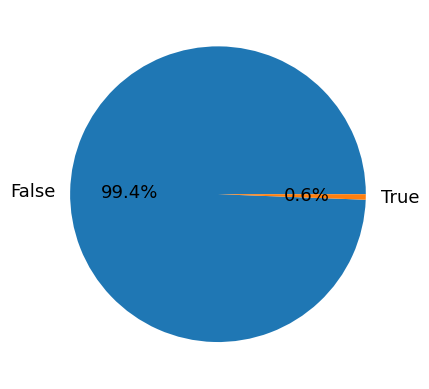

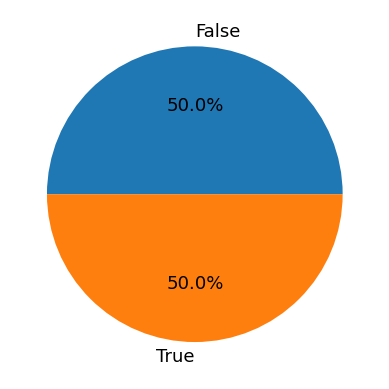

Accuracy: 0.8177529267866503
Confusion Matrix:
 [[9322 2062]
 [  24   38]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.82      0.90     11384
        True       0.02      0.61      0.04        62

    accuracy                           0.82     11446
   macro avg       0.51      0.72      0.47     11446
weighted avg       0.99      0.82      0.89     11446

Average Precision: 0.017859547007640076
Recall at 100: 0.016129032258064516
ROC AUC: 0.7631062555255821


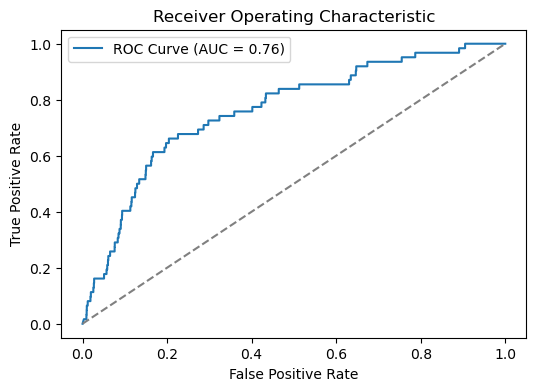

Accuracy: 0.8891117797837959
Confusion Matrix:
 [[7951  986]
 [   9   27]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.89      0.94      8937
        True       0.03      0.75      0.05        36

    accuracy                           0.89      8973
   macro avg       0.51      0.82      0.50      8973
weighted avg       0.99      0.89      0.94      8973

Average Precision: 0.028413200276185522
Recall at 100: 0.05555555555555555
ROC AUC: 0.8940515708726519


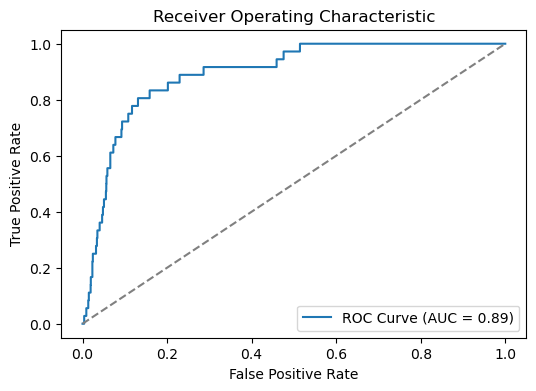

In [ ]:

# Split into Train and Test using 'bankruptcy_prediction_split'
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

numeric_cols = [
   'revenues','operating_expenses', 'operating_income', 'net_income',
   'earnings_per_share_basic', 'earnings_per_share_diluted',
   'total_current_assets', 'total_noncurrent_assets', 'total_assets',
   'total_current_liabilities', 'total_noncurrent_liabilities',
   'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
   'net_cash_from_operating_activities','net_cash_from_investing_activities',
   'net_cash_from_financing_activities', 'cash','other_comprehensive_income'
]

mean = train_df[numeric_cols].mean()
mean_test = test_df[numeric_cols].mean()
print("shape before drop na ", train_df.shape)
# train_df = train_df.fillna(mean)
train_df = train_df.dropna()

print("shape after drop na ", train_df.shape)
print("shape before drop na ", test_df.shape)
# test_df = test_df.fillna(mean_test)
test_df = test_df.dropna()

print("shape after drop na ", test_df.shape)
# Define X and y for each split
#    Remove the 'bankruptcy_prediction_split' column before modeling
X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

# Dealing with class imbalance
sm = SMOTE(sampling_strategy='minority', random_state=42)
print("cols ", X_train.columns)

# Fit SMOTE on the training data to oversample the minority class
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
oversampled = pd.concat([pd.DataFrame(y_train_res), pd.DataFrame(X_train_res)], axis=1)

df.groupby('label').size().plot(kind='pie',
                                       autopct='%.1f%%',
                                       fontsize=13)
plt.show()

oversampled.groupby('label').size().plot(kind='pie',
                                       autopct='%.1f%%',
                                       fontsize=13)
                                    #    labels=['bankrupt','not bankrupt'],
                                    #    colors=['skyblue', 'tomato'])
plt.show()

# Create and fit the LR model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_res, y_train_res)

# 6. Predict on the test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for positive class

evaluate_lr(y_pred, y_proba, y_test)

y_pred = logreg.predict(X_train)
y_proba = logreg.predict_proba(X_train)[:, 1]  # Probabilities for positive class

evaluate_lr(y_pred, y_proba, y_train)


# TODO: FIX SMOTE HERE
# fix underfitting
# attempt to increase AP
# undersample the negatives 

# use different train test splits: 
# train test split using group split by cik (stratify )
# use  the above method to calculate fit the data with multiple random seeds, then calculate (mean AUCPR ± std AUCPR)
# (maybe try to plot the decision boundary)


#  Try more models: 
# XGBOOST, SVM w nonLinearKernel, 


# Next meeting: 
# A table comparing various models and their metrics (Recall @ 100, AP)
# compare our custom train-test split(multiple runs) with the ecl train-test split (1 run)
# for the custom train split use train_test_split(random_seed-i) (inside a for loop)


Accuracy: 0.916390005242006
Confusion Matrix:
 [[10464   920]
 [   37    25]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.92      0.96     11384
        True       0.03      0.40      0.05        62

    accuracy                           0.92     11446
   macro avg       0.51      0.66      0.50     11446
weighted avg       0.99      0.92      0.95     11446

Average Precision: 0.028032932445760675
Recall at 100: 0.04838709677419355
ROC AUC: 0.8390390871171762


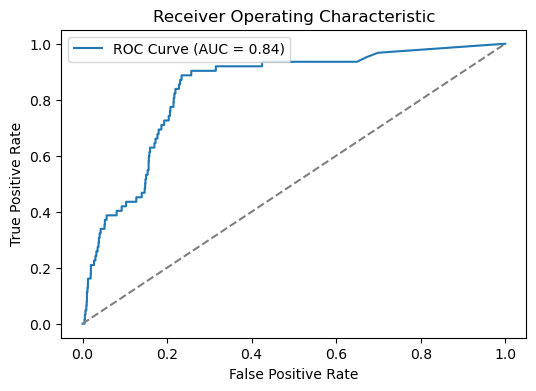

Accuracy: 0.8891117797837959
Confusion Matrix:
 [[7951  986]
 [   9   27]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.89      0.94      8937
        True       0.03      0.75      0.05        36

    accuracy                           0.89      8973
   macro avg       0.51      0.82      0.50      8973
weighted avg       0.99      0.89      0.94      8973

Average Precision: 0.028413200276185522
Recall at 100: 0.05555555555555555
ROC AUC: 0.8940515708726519


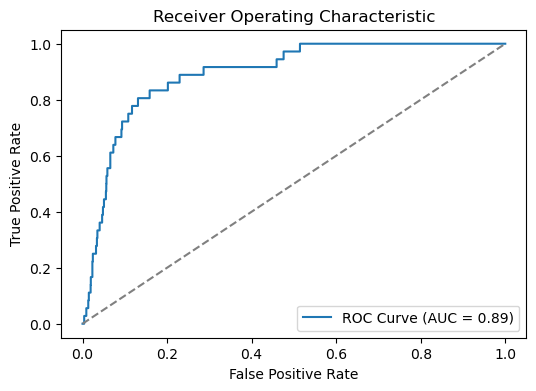

In [87]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=500)
clf.fit(X_train_res, y_train_res)

# 6. Predict on the test set
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for positive class

evaluate_lr(y_pred, y_proba, y_test)


print( " ==================    ")

y_pred = logreg.predict(X_train)
y_proba = logreg.predict_proba(X_train)[:, 1]  # Probabilities for positive class

evaluate_lr(y_pred, y_proba, y_train)







In [4]:
# df = pd.read_csv("../outputs/ecl_companyfacts_processed.csv")
# print("before drop na: ", df.shape)
# label_frequency_date_1 = df["label"].sum()
# cols_to_drop = ['bankruptcy_prediction_split', 'filename', 'period_of_report', 'gvkey', 'datadate', 'can_label', 'qualified', 'bankruptcy_date_1', 'bankruptcy_date_2', 'bankruptcy_date_3', 'filing_date', 'cik_year', 'opinion_text'] 
# df.drop(columns=cols_to_drop, inplace=True, errors='ignore')


# print(f"Label frequency for label (before drop): {label_frequency_date_1} / {len(df)}")

# print("Number of NaNs in 'item_7':", df['item_7'].isna().sum())
# print("Number of empty strings in 'item_7':", (df['item_7'] == "").sum())
# # df = df.dropna(subset=['item_7'])
# df.dropna(inplace=True)
# print("shape after drop: ", df.shape)
# label_frequency_date_1 = df["label"].sum()
# print(f"Label frequency for label: {label_frequency_date_1} / {len(df)}")

before drop na:  (21740, 26)
Label frequency for label (before drop): 133 / 21740
Number of NaNs in 'item_7': 134
Number of empty strings in 'item_7': 0
shape after drop:  (21606, 13)
Label frequency for label: 132 / 21606


## Logistic Regression (Numeric Cols + item_7 text)

In [52]:
from tools.utils import extract_year_from_filename

ecl = pd.read_json(config.ECL_FILE_PATH, lines=True)
financials_df = pd.read_csv(os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv'))



print("shapes ", ecl.shape, financials_df.shape)
ecl["year"] = pd.to_numeric(ecl["filename"].apply(extract_year_from_filename))
ecl = ecl.loc[ecl["year"] >= 2010].reset_index(drop=True) # reset index so the two dataframes indices are not misaligned for the join
print("shapes ", ecl.shape, financials_df.shape)

reports_text = ecl[['item_7', 'opinion_text']]
financials_df = pd.concat([financials_df, reports_text], axis=1)

financials_df = financials_df.drop(
    financials_df[(financials_df.isXBRL == 0) & (financials_df.bankruptcy_prediction_split == 'train')].index
)
print('Final columns and shape of financials df: ', financials_df.shape, "\n", financials_df.columns)


C:\Users\Angelo\AppData\Local\Temp\ipykernel_23172\1238614767.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  financials_df = pd.read_csv(os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv'))


shapes  (68620, 18) (36788, 42)
shapes  (36788, 19) (36788, 42)
Final columns and shape of financials df:  (32204, 44) 
 Index(['cik', 'company', 'period_of_report', 'gvkey', 'datadate', 'filename',
       'can_label', 'qualified', 'label', 'bankruptcy_prediction_split',
       'bankruptcy_date_1', 'bankruptcy_date_2', 'bankruptcy_date_3',
       'filing_date', 'cik_year', 'gc_list', 'year', 'accessionNumber',
       'reportDateIndex', 'form', 'primaryDocument', 'isXBRL', 'revenues',
       'operating_expenses', 'operating_income', 'net_income',
       'earnings_per_share_basic', 'earnings_per_share_diluted',
       'total_current_assets', 'total_noncurrent_assets', 'total_assets',
       'total_current_liabilities', 'total_noncurrent_liabilities',
       'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
       'net_cash_from_operating_activities',
       'net_cash_from_investing_activities',
       'net_cash_from_financing_activities', 'net_increase_decrease_in_c

In [ ]:
mean = financials_df[numeric_cols].mean()
print("shape before drop na ", financials_df.shape)
financials_df = financials_df.fillna(mean)
print("na counts:\n", financials_df.isna().sum())

cols_to_drop = [
    'filename', 'period_of_report', 'gvkey', 'datadate',
    'can_label', 'qualified', 'primaryDocument', 
    'bankruptcy_date_1', 'bankruptcy_date_2','bankruptcy_date_3',
    'filing_date', 'cik_year',
    'revenues','operating_expenses', 'operating_income', 'net_income',
    'earnings_per_share_basic', 'earnings_per_share_diluted',
    'total_current_assets', 'total_noncurrent_assets', 'total_assets',
    'total_current_liabilities', 'total_noncurrent_liabilities',
    'total_liabilities', 'stockholders_equity', 'total_liabilities_equity',
    'net_cash_from_operating_activities','net_cash_from_investing_activities',
    'net_cash_from_financing_activities', 'cash','other_comprehensive_income'
]

shape before drop na  (32204, 44)
na counts:
 cik                                       0
company                                   0
period_of_report                          0
gvkey                                     0
datadate                                  0
filename                                  0
can_label                                 0
qualified                                 0
label                                     0
bankruptcy_prediction_split               0
bankruptcy_date_1                     30272
bankruptcy_date_2                     32050
bankruptcy_date_3                     32198
filing_date                               0
cik_year                                  0
gc_list                                   0
year                                      0
accessionNumber                           0
reportDateIndex                           0
form                                      0
primaryDocument                           0
isXBRL                        

Starting Shape:  (32204, 31)
Label counts on the test set, before drop na: 
 label
False    18153
True       122
Name: count, dtype: int64
After dropping NAs from item_7 and opinion_text:  (32204, 31)
Label counts on the test set, after drop na: 
 label
False    18153
True       122
Name: count, dtype: int64
Accuracy: 0.9807934336525308
Confusion Matrix:
 [[17862   291]
 [   60    62]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.98      0.99     18153
        True       0.18      0.51      0.26       122

    accuracy                           0.98     18275
   macro avg       0.59      0.75      0.63     18275
weighted avg       0.99      0.98      0.99     18275

Average Precision: 0.18277620468360592
Recall at 100: 0.2786885245901639
ROC AUC: 0.9315946512927908


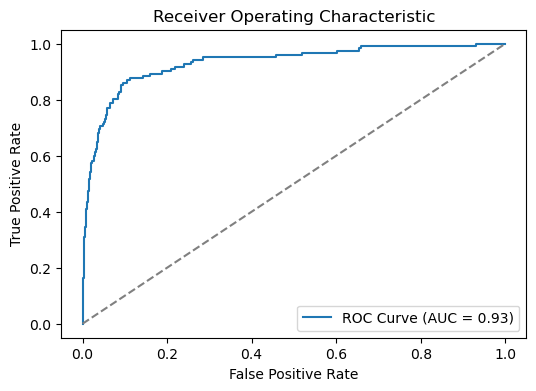

In [71]:
# df = pd.read_csv(config.POST_PROCESSED_DATASET_FILEPATH) # os.path.join(config.OUTPUT_DIR, 'ecl_with_financial_tags.csv')
df = financials_df


cols_to_drop = [
    'cik','filename', 'period_of_report', 'gvkey', 'datadate',
    'can_label', 'qualified', 'primaryDocument', 
    'bankruptcy_date_1', 'bankruptcy_date_2','bankruptcy_date_3',
    'filing_date', 'cik_year'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Drop rows where 'item_7' or 'opinion_text' is NA (if desired)
print("Starting Shape: ", df.shape)
print("Label counts on the test set, before drop na: \n", df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))
df = df.dropna(subset=['item_7', 'opinion_text'])
print("After dropping NAs from item_7 and opinion_text: ", df.shape)
print("Label counts on the test set, after drop na: \n", df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))

# Separate Target
y = df['label'].astype(int)

# Split into Train and Test using 'bankruptcy_prediction_split'
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

# Define X and y for each split
#    Remove the 'bankruptcy_prediction_split' column before modeling
X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

# Identify Numeric and Text Columns
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns
text_cols = ['item_7', 'opinion_text']  # We'll transform both text features

# Build a ColumnTransformer
#    - TF-IDF Vectorizer for each text column (removing English stopwords)
#    - StandardScaler for numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ("item_7_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "item_7"),
        ("opinion_text_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "opinion_text"),
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

# Create a Pipeline
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(sampling_strategy='minority', random_state=42)),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit the Pipeline on the Training Data
pipeline.fit(X_train, y_train)

# Predict on the Test Set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Evaluate Results
evaluate_lr(y_pred, y_proba, y_test)



In [60]:
# Check basic descriptive stats of numeric columns
print(X_train[numeric_cols].describe())

# After fitting the pipeline, let's see how the scaler transformed them:
preprocessor.named_transformers_['num'].fit(X_train[numeric_cols])
scaled_values = preprocessor.named_transformers_['num'].transform(X_train[numeric_cols])
scaled_df = pd.DataFrame(scaled_values, columns=numeric_cols)
print(scaled_df.describe())

                cik        Assets  CashAndCashEquivalentsAtCarryingValue  \
count  9.760000e+03  9.760000e+03                           9.760000e+03   
mean   8.705505e+05  1.453577e+10                           5.766643e+08   
std    4.618845e+05  2.961749e+11                           3.007616e+09   
min    1.750000e+03  0.000000e+00                           0.000000e+00   
25%    7.267698e+05  6.899420e+08                           3.234370e+07   
50%    9.310150e+05  1.798502e+09                           1.015665e+08   
75%    1.177632e+06  5.812330e+09                           3.434495e+08   
max    1.645590e+06  2.812102e+13                           1.213390e+11   

       IncomeTaxExpenseBenefit  LiabilitiesAndStockholdersEquity  \
count             9.760000e+03                      9.760000e+03   
mean              1.422383e+08                      1.203446e+10   
std               1.030459e+09                      8.576211e+10   
min              -3.483100e+10             

Starting Shape:  (32204, 31)
Label counts on the test set, before drop na: 
 label
False    18153
True       122
Name: count, dtype: int64
After dropping NAs from item_7 and opinion_text:  (32204, 31)
Label counts on the test set, after drop na: 
 label
False    18153
True       122
Name: count, dtype: int64
Accuracy: 0.9765253077975377
Confusion Matrix:
 [[17777   376]
 [   53    69]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.98      0.99     18153
        True       0.16      0.57      0.24       122

    accuracy                           0.98     18275
   macro avg       0.58      0.77      0.62     18275
weighted avg       0.99      0.98      0.98     18275

Average Precision: 0.17828817060325877
Recall at 100: 0.23770491803278687
ROC AUC: 0.9324263794179347


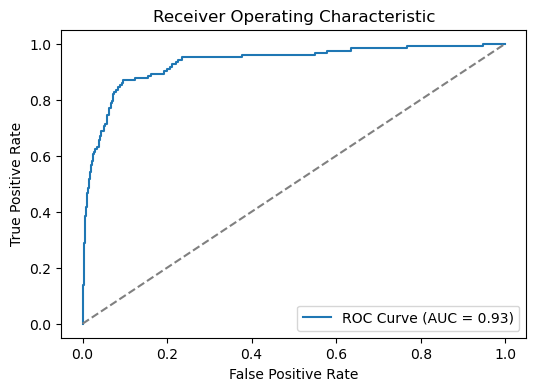

In [ ]:
from scipy.sparse import hstack, csr_matrix

df = financials_df

cols_to_drop = [
    'cik','filename', 'period_of_report', 'gvkey', 'datadate',
    'can_label', 'qualified', 'primaryDocument', 
    'bankruptcy_date_1', 'bankruptcy_date_2','bankruptcy_date_3',
    'filing_date', 'cik_year'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Starting Shape: ", df.shape)
print("Label counts on the test set, before drop na: \n", 
      df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))

df = df.dropna(subset=['item_7', 'opinion_text'])

print("After dropping NAs from item_7 and opinion_text: ", df.shape)
print("Label counts on the test set, after drop na: \n", 
      df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))

y = df['label'].astype(int)

train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']
X_test  = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test  = test_df['label']

numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns

# Combine text from both columns for fitting TF-IDF outside pipeline
combined_text = pd.concat([X_train['item_7'], X_train['opinion_text']])
shared_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
shared_vectorizer.fit(combined_text)

# Transform each text column in X_train
X_item7_train    = shared_vectorizer.transform(X_train['item_7'])
X_opinion_train  = shared_vectorizer.transform(X_train['opinion_text'])
X_text_train     = hstack([X_item7_train, X_opinion_train])  # merged TF-IDF features

# Scale numeric columns
scaler = StandardScaler()
X_numeric_train = scaler.fit_transform(X_train[numeric_cols])
X_numeric_train_sparse = csr_matrix(X_numeric_train)  # convert to sparse to combine

# Concatenate TF-IDF + numeric
X_train_combined = hstack([X_text_train, X_numeric_train_sparse])

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy='minority', random_state=42)),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit pipeline on the preprocessed training data
pipeline.fit(X_train_combined, y_train)

# Preprocess the Test Data the Same Way
X_item7_test    = shared_vectorizer.transform(X_test['item_7'])
X_opinion_test  = shared_vectorizer.transform(X_test['opinion_text'])
X_text_test     = hstack([X_item7_test, X_opinion_test])

X_numeric_test  = scaler.transform(X_test[numeric_cols])
X_numeric_test_sparse = csr_matrix(X_numeric_test)
X_test_combined = hstack([X_text_test, X_numeric_test_sparse])


y_pred  = pipeline.predict(X_test_combined)
y_proba = pipeline.predict_proba(X_test_combined)[:, 1]

# Evaluate
evaluate_lr(y_pred, y_proba, y_test)


In [51]:
# df = pd.read_json("../outputs/ecl_companyfacts.json", lines=True)

print("Bankruptcy label distribution:")
print(df[df['bankruptcy_prediction_split'] == 'test'].value_counts(subset=['label']))

test_df  = df[df['bankruptcy_prediction_split'] == 'test']

print(test_df[test_df['label'] == None])

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

print(X_test.isna().sum(axis=0))


# Predict on the Test Set
# y_pred = pipeline.predict(X_test)
# y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# # Evaluate Results
# evaluate_lr(y_pred, y_proba, y_test)


Bankruptcy label distribution:
label
False    17125
True       110
Name: count, dtype: int64
Empty DataFrame
Columns: [cik, company, period_of_report, gvkey, datadate, filename, can_label, qualified, label, bankruptcy_prediction_split, bankruptcy_date_1, bankruptcy_date_2, bankruptcy_date_3, filing_date, cik_year, opinion_text, gc_list, item_7, AccountsPayableCurrent, AccountsReceivableNetCurrent, AccruedLiabilitiesCurrent, AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment, AccumulatedOtherComprehensiveIncomeLossNetOfTax, AdditionalPaidInCapitalCommonStock, AdjustmentsToAdditionalPaidInCapitalTaxEffectFromShareBasedCompensation, AmortizationOfDebtDiscountPremium, AssetImpairmentCharges, Assets, AssetsCurrent, AssetsNoncurrent, BuildingsAndImprovementsGross, CapitalLeaseObligationsCurrent, CapitalLeaseObligationsNoncurrent, CashAndCashEquivalentsAtCarryingValue, CashAndCashEquivalentsPeriodIncreaseDecrease, CommonStockParOrStatedValuePerShare, CommonStockSharesAut

In [ ]:

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

evaluate_lr(y_pred, y_proba, y_test)


In [ ]:
train_df = df[df['bankruptcy_prediction_split'] == 'train']
test_df  = df[df['bankruptcy_prediction_split'] == 'test']

X_train = train_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bankruptcy_prediction_split'], errors='ignore')
y_test = test_df['label']

print(train_df.shape, test_df.shape)
print(y_train.value_counts())
print(y_test.value_counts())

In [12]:

text_cols = ['item_7', 'opinion_text']
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("item_7_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "item_7"),
        ("opinion_text_tfidf", TfidfVectorizer(max_features=5000, stop_words='english'), "opinion_text"),
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

# 1. Fit the preprocessor on the training data (TF-IDF is unsupervised, so only X is needed)
preprocessor.fit(X_train)

# 2. Transform X_train
X_train_pre = preprocessor.transform(X_train)
# 3. Transform X_test (use the same fitted preprocessor)
X_test_pre = preprocessor.transform(X_test)

print("X_train_pre shape:", X_train_pre.shape)
print("X_test_pre shape:", X_test_pre.shape)

X_train_pre shape: (9760, 10009)
X_test_pre shape: (11846, 10009)
